In [1]:
import os, sys, json, time, warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm

In [2]:
NB_DIR = os.path.abspath(os.getcwd())
ROOT_DIR = os.path.abspath(os.path.join(NB_DIR, ".."))
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

from core.model import TumorNet34Bayes
from core.utils import set_seed, FocalLoss, EarlyStoppingAUC, compute_metrics, save_json

# Root results folder
ROOT_RESULTS = r"E:\Multi-scale Self-Attention Guided MRI Feature Fusion Network for Brain Tumor Presence Detection with Uncertainty and Weak Localization\results"
CKPT_DIR     = os.path.join(ROOT_RESULTS, "checkpoints")
VIZ_DIR      = os.path.join(ROOT_RESULTS, "visualizations")
LOGS_DIR     = os.path.join(ROOT_RESULTS, "logs")

for d in [ROOT_RESULTS, CKPT_DIR, VIZ_DIR, LOGS_DIR]:
    os.makedirs(d, exist_ok=True)

In [3]:
set_seed(42)
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [4]:
X_train = np.load(os.path.join(ROOT_DIR, "data", "processed", "X_train.npy"))
y_train = np.load(os.path.join(ROOT_DIR, "data", "processed", "y_train.npy"))
X_val   = np.load(os.path.join(ROOT_DIR, "data", "processed", "X_val.npy"))
y_val   = np.load(os.path.join(ROOT_DIR, "data", "processed", "y_val.npy"))

X_train_t = torch.tensor(X_train, dtype=torch.float32).permute(0,3,1,2)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32).permute(0,3,1,2)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32).unsqueeze(1)

BATCH_SIZE = 16
NUM_WORKERS = 0  
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

Train batches: 175 | Val batches: 38


In [5]:
model = TumorNet34Bayes(dropout_p=0.4).to(device)

criterion = FocalLoss(alpha=1.0, gamma=2.0, reduction='none')
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

scaler = GradScaler()
early = EarlyStoppingAUC(patience=7, min_delta=1e-4)

EPOCHS = 12
best_val_auc = -1.0
history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_auc": [], "val_f1": []}

In [6]:
for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]", leave=False)
    for xb, yb in pbar:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            logits, probs, conf = model(xb)                      
            per_sample_loss = criterion(logits, yb)
            loss = (per_sample_loss * torch.clamp(conf, 0.1, 1.0)).mean()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * xb.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_running_loss = 0.0
    all_probs, all_labels = [], []
    with torch.no_grad(), autocast(enabled=True):
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [val]  ", leave=False)
        for xb, yb in pbar_val:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            logits, probs, conf = model(xb)
            per_sample_loss = criterion(logits, yb)
            batch_loss = (per_sample_loss * torch.clamp(conf, 0.1, 1.0)).mean()
            val_running_loss += batch_loss.item() * xb.size(0)

            probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
            labels = yb.detach().cpu().numpy().ravel()
            all_probs.extend(probs.tolist())
            all_labels.extend(labels.tolist())

    val_loss = val_running_loss / len(val_loader.dataset)
    metrics = compute_metrics(np.array(all_labels), np.array(all_probs), threshold=0.5)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(metrics["acc"])
    history["val_auc"].append(metrics["auc"])
    history["val_f1"].append(metrics["f1"])

    # print concise epoch summary
    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train {train_loss:.4f} | Val {val_loss:.4f} | "
          f"AUC {metrics['auc']:.4f} | Acc {metrics['acc']:.4f} | F1 {metrics['f1']:.4f}")

    if metrics["auc"] > best_val_auc + 1e-6:
        best_val_auc = metrics["auc"]
        torch.save(model.state_dict(), os.path.join(CKPT_DIR, "model_weights_best.pth"))
        torch.save(model, os.path.join(CKPT_DIR, "tumornet_best.pkl"))
        print("✅ Saved best checkpoint (by AUC)")

    early.step(1.0 - metrics["auc"])  
    if early.should_stop:
        print("⏹️ Early stopping triggered")
        break

    scheduler.step(epoch)

Epoch 1/12 [train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 1/12 [val]  :   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 1/12 | Train 1.2846 | Val 1.3316 | AUC 0.9545 | Acc 0.8617 | F1 0.8725
✅ Saved best checkpoint (by AUC)


Epoch 2/12 [train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 2/12 [val]  :   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 2/12 | Train 0.7046 | Val 1.0253 | AUC 0.9814 | Acc 0.9083 | F1 0.9139
✅ Saved best checkpoint (by AUC)


Epoch 3/12 [train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 3/12 [val]  :   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 3/12 | Train 0.4859 | Val 0.7370 | AUC 0.9835 | Acc 0.9550 | F1 0.9552
✅ Saved best checkpoint (by AUC)


Epoch 4/12 [train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 4/12 [val]  :   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 4/12 | Train 0.3846 | Val 0.7778 | AUC 0.9864 | Acc 0.9517 | F1 0.9521
✅ Saved best checkpoint (by AUC)


Epoch 5/12 [train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 5/12 [val]  :   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 5/12 | Train 0.2907 | Val 0.8376 | AUC 0.9898 | Acc 0.9367 | F1 0.9329
✅ Saved best checkpoint (by AUC)


Epoch 6/12 [train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 6/12 [val]  :   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 6/12 | Train 0.4342 | Val 2.0740 | AUC 0.9659 | Acc 0.8467 | F1 0.8667


Epoch 7/12 [train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 7/12 [val]  :   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 7/12 | Train 0.3137 | Val 0.9074 | AUC 0.9884 | Acc 0.9383 | F1 0.9347


Epoch 8/12 [train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 8/12 [val]  :   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 8/12 | Train 0.2302 | Val 0.5573 | AUC 0.9913 | Acc 0.9750 | F1 0.9745
✅ Saved best checkpoint (by AUC)
⏹️ Early stopping triggered


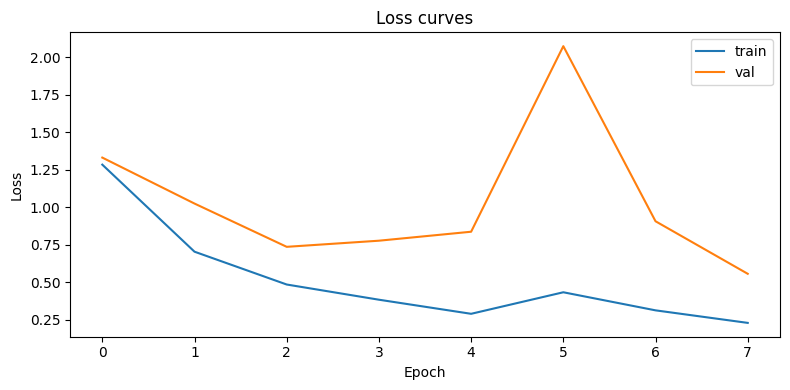

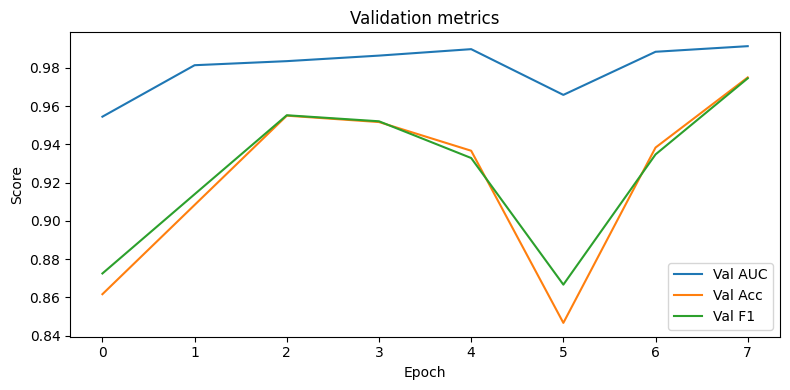

In [7]:
plt.figure(figsize=(8,4))
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss curves")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, "loss_curves.png")); plt.show()

plt.figure(figsize=(8,4))
plt.plot(history["val_auc"], label="Val AUC")
plt.plot(history["val_acc"], label="Val Acc")
plt.plot(history["val_f1"],  label="Val F1")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Validation metrics")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, "val_metrics.png")); plt.show()

In [8]:
torch.save(model.state_dict(), os.path.join(CKPT_DIR, "model_weights_last.pth"))
torch.save(model, os.path.join(CKPT_DIR, "tumornet_last.pkl"))

dummy = torch.randn(1,3,224,224, device=device)
torch.onnx.export(model, dummy, os.path.join(CKPT_DIR, "tumornet.onnx"),
                  input_names=["input"], output_names=["logits_conf"], opset_version=12)

save_json(os.path.join(ROOT_RESULTS, "metrics.json"), {
    "history": history,
    "best_val_auc": float(best_val_auc),
    "epochs_run": len(history["train_loss"])
})

print(f"✅ Training complete. Artifacts saved to:\n{ROOT_RESULTS}")

✅ Training complete. Artifacts saved to:
E:\Multi-scale Self-Attention Guided MRI Feature Fusion Network for Brain Tumor Presence Detection with Uncertainty and Weak Localization\results
